# Setup Environment
Set up the environment by importing necessary libraries and setting up API keys.

In [190]:
# # Install required packages
# !pip install --quiet langgraph langsmith langchain_openai playwright nest_asyncio
# # Install Playwright browser
# !playwright install

# Import necessary libraries
import os
import nest_asyncio

from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Set OpenAI API key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Apply nest_asyncio for running async code in Jupyter
nest_asyncio.apply()

# Define A Helper File

Make sure to create a JS code file called mark_page.js in the same folder as the notebook

# Define Agent State
Define the `AgentState` class to represent the state of the agent, including the webpage, bounding boxes, and predictions.

In [191]:
from typing import List, Optional, Any, Dict
from pydantic import BaseModel, Field, ConfigDict
from langchain_core.messages import BaseMessage
from playwright.async_api import Page
import base64
import asyncio

# Define the BBox model
class BBox(BaseModel):
    """
    Represents a bounding box on the webpage with its coordinates and metadata.
    """
    x: float
    y: float
    text: str
    type: str
    ariaLabel: Optional[str] = None
    id: Optional[str] = None

# Define the Prediction model
class Prediction(BaseModel):
    """
    Represents the agent's predicted action and its arguments.
    """
    action: str = Field(description="The action to be performed by the agent")
    args: List[str] = Field(default_factory=list, description="Arguments for the action")

# Define the AgentState model
class AgentState(BaseModel):
    """
    Represents the state of the agent during execution.
    """
    page: Any = Field(default=None, exclude=True)  # Non-serializable Playwright page object
    input: str = ""
    img: Optional[str] = ""
    bboxes: Optional[List[BBox]] = Field(default_factory=list, description="List of bounding boxes annotated on the webpage")
    prediction: Optional[Prediction] = Field(description="The agent's predicted action and arguments")
    scratchpad: Optional[List[BaseMessage]] = Field(default_factory=list, description="Intermediate steps or system messages")
    observation: Optional[str] = ""
    ids: Optional[List[int]] = Field(default_factory=list)

    class Config:
        # Exclude the `page` attribute during serialization
        arbitrary_types_allowed = True
        json_encoders = {
            Page: lambda v: None,  # Prevent serialization of arbitrary objects
        }


# Define Tools
Implement the tools for the agent, such as 

1. `click`, 

2. `type_text`, 

3. `scroll`, 

4. `wait`,

5. `go_back`, 

5. `to_google`.

In [192]:
import asyncio
import platform

async def click(state: AgentState):
    """
    Simulates a mouse click on a bounding box identified by its label.
    """
    try:
        page = state.page
        click_args = state.prediction.args
        if click_args is None or len(click_args) != 1:
            state.observation = f"Failed to click bounding box labeled as number {click_args}"
            return state
        bbox_id = int(click_args[0])
        print("Bbox ID clicked: ", bbox_id)
        try:
            bbox = state.bboxes[bbox_id]
            print("Bbox: ", bbox)
            state.ids.append(bbox_id)
        except IndexError:
            state.observation = f"Error: no bounding box for label {bbox_id}"
            return state
        x, y = bbox.x, bbox.y

        await page.mouse.click(x, y)
        state.observation = f"Clicked {bbox_id}"
    except Exception as e:
        state.observation = f"Error during click: {e}"
        print(f"Error in click: {e}")
    return state


async def type_text(state: AgentState):
    """
    Simulates typing text into an input field identified by a bounding box label.
    """
    try:
        page = state.page
        type_args = state.prediction.args
        if type_args is None or len(type_args) != 2:
            state.observation = f"Failed to type in element from bounding box labeled as number {type_args}"
            return state
        bbox_id = int(type_args[0])
        text_content = type_args[1]
        try:
            bbox = state.bboxes[bbox_id]
        except IndexError:
            state.observation = f"Error: no bounding box for label {bbox_id}"
            return state
        x, y = bbox.x, bbox.y
        await page.mouse.click(x, y)
        select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
        await page.keyboard.press(select_all)
        await page.keyboard.press("Backspace")
        await page.keyboard.type(text_content)
        await page.keyboard.press("Enter")
        state.observation = f"Typed '{text_content}' and submitted"
    except Exception as e:
        state.observation = f"Error during type_text: {e}"
        print(f"Error in type_text: {e}")
    return state


async def scroll(state: AgentState):
    """
    Simulates scrolling within the webpage or a specific element.
    """
    try:
        page = state.page
        scroll_args = state.prediction.args
        if scroll_args is None or len(scroll_args) != 2:
            state.observation = "Failed to scroll due to incorrect arguments."
            return state
        target, direction = scroll_args

        if target.upper() == "WINDOW":
            scroll_amount = 500
            scroll_direction = (
                -scroll_amount if direction.lower() == "up" else scroll_amount
            )
            await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
        else:
            scroll_amount = 200
            target_id = int(target)
            try:
                bbox = state.bboxes[target_id]
                x, y = bbox.x, bbox.y
                await page.mouse.move(x, y)
                scroll_direction = (
                    -scroll_amount if direction.lower() == "up" else scroll_amount
                )
                await page.mouse.wheel(0, scroll_direction)
            except IndexError:
                state.observation = f"Error: no bounding box for label {target_id}"
                return state

        state.observation = f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"
    except Exception as e:
        state.observation = f"Error during scroll: {e}"
        print(f"Error in scroll: {e}")
    return state


async def wait(state: AgentState):
    """
    Simulates a wait action for a fixed duration.
    """
    try:
        sleep_time = 5
        await asyncio.sleep(sleep_time)
        state.observation = f"Waited for {sleep_time} seconds"
    except Exception as e:
        state.observation = f"Error during wait: {e}"
        print(f"Error in wait: {e}")
    return state


async def go_back(state: AgentState):
    """
    Simulates navigating back to the previous page in the browser.
    """
    try:
        page = state.page
        await page.go_back()
        state.observation = f"Navigated back to {page.url}"
    except Exception as e:
        state.observation = f"Error during go_back: {e}"
        print(f"Error in go_back: {e}")
    return state


async def to_google(state: AgentState):
    """
    Simulates navigating to the Google homepage.
    """
    try:
        page = state.page
        await page.goto("https://www.google.com/")
        state.observation = "Navigated to google.com"
    except Exception as e:
        state.observation = f"Error during to_google: {e}"
        print(f"Error in to_google: {e}")
    return state

async def approve_info_box(state: AgentState):
    """
    Simulates clicking the 'Approve' button in a Google information box.
    """
    try:
        page = state.page
        approve_args = state.prediction.args
        if approve_args is None or len(approve_args) != 1:
            state.observation = f"Failed to approve due to incorrect arguments: {approve_args}"
            return state
        bbox_id = int(approve_args[0])
        try:
            bbox = state.bboxes[bbox_id]
            print("Bbox: ", bbox)
        except IndexError:
            state.observation = f"Error: no bounding box for label {bbox_id}"
            return state
        x, y = bbox.x, bbox.y

        # Simulate clicking the 'Approve' button
        await page.mouse.click(x, y)
        state.observation = f"Clicked 'Approve' button for bounding box {bbox_id}"
    except Exception as e:
        state.observation = f"Error during approve_info_box: {e}"
        print(f"Error in approve_info_box: {e}")
    return state

In [193]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Load the prompt template for the agent
prompt = hub.pull("wfh/web-voyager")

# Initialize the LLM with gpt-4o
#llm = ChatOpenAI(model="gpt-4o")

# Define the structured output schema
class StrOutput(BaseModel):
    """
    Represents the structured output of the LLM.
    """
    thought: str = Field(..., description="Your brief thoughts (briefly summarize the info that will help ANSWER)")
    action: str = Field(..., description="The action you want to take")
    args: list[str] = Field(..., description="The arguments for the action")

# Initialize the LLM with gpt-4o and structured output
structured_llm = ChatOpenAI(model="gpt-4o").with_structured_output(schema=StrOutput)

/home/teodorrk/projects/cogitoxinfor-agents/.myvenv/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [194]:
prompt.to_json()

{'lc': 1,
 'type': 'constructor',
 'id': ['langchain', 'prompts', 'chat', 'ChatPromptTemplate'],
 'kwargs': {'input_variables': ['bbox_descriptions', 'img', 'input'],
  'optional_variables': ['scratchpad'],
  'partial_variables': {'scratchpad': []},
  'metadata': {'lc_hub_owner': 'wfh',
   'lc_hub_repo': 'web-voyager',
   'lc_hub_commit_hash': '8b9276048be8aec78203e8c45c9e15bc3a46e4b3275b05ef727563a2887ebaab'},
  'messages': [SystemMessagePromptTemplate(prompt=[PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="Imagine you are a robot browsing the web, just like humans. Now you need to complete a task. In each iteration, you will receive an Observation that includes a screenshot of a webpage and some texts. This screenshot will\nfeature Numerical Labels placed in the TOP LEFT corner of each Web Element. Carefully analyze the visual\ninformation to identify the Numerical Label corresponding to the Web Element that requires interaction, then follow\nthe gu

# Define Browser Annotations
Define the `mark_page` function to annotate the browser page with bounding boxes for the agent to interact with.

# Define Agent
Compose the agent using the annotation function, prompt, LLM, and output parser.

In [195]:
import base64
from langchain_core.runnables import chain as chain_decorator

# Load the JavaScript code for annotating the page
with open("mark_page.js") as f:
    # Some JavaScript we will run on each step
    # to take a screenshot of the page, select the
    # elements to annotate, and add bounding boxes
    mark_page_script = f.read()

@chain_decorator
async def mark_page(page: Page):
    """
    Annotates the current browser page with bounding boxes for interactive elements.
    """
    # Execute the JavaScript code to annotate the page
    await page.evaluate(mark_page_script)
    for _ in range(10):  # Retry up to 10 times in case of loading delays
        try:
            bboxes = await page.evaluate("markPage()")  # Get bounding boxes
            break
        except Exception:
            await asyncio.sleep(3)  # Wait before retrying
    screenshot = await page.screenshot()  # Take a screenshot of the page
    await page.evaluate("unmarkPage()")  # Remove annotations after capturing
    bboxes = await page.evaluate("markPage()")  # Get bounding boxes
    return {
        "img": base64.b64encode(screenshot).decode(),  # Encode screenshot as base64
        "bboxes": bboxes,  # Return bounding boxes
    }

async def annotate(state: AgentState):
    try:
        # Annotate the page and get bounding boxes
        marked_page = await mark_page.with_retry().ainvoke(state.page)
        print("Annotated bounding boxes:", marked_page["bboxes"])  # Log the bounding boxes
        state.img = marked_page["img"]  # Set the annotated image
        state.bboxes = [
            BBox(**bbox) for bbox in marked_page["bboxes"]
        ]  # Convert bounding boxes to BBox objects

        # Check if any bounding box is of type 'iframe'
        iframe_bbox = next((bbox for bbox in marked_page["bboxes"] if bbox["type"] == "iframe"), None)
        if iframe_bbox:
            print("Iframe detected. Switching to iframe context...")
            # Switch to the iframe context
            iframe_selector = f"iframe"  # Adjust selector if needed
            iframe = state.page.frame_locator(iframe_selector)
            if not iframe:
                raise Exception("Iframe not found")
            state.page = iframe  # Update the state to use the iframe context
        else:
            print("No iframe detected. Proceeding with normal page context...")

    except Exception as e:
        state.observation = f"Error during annotation: {e}"
        print(f"Error in annotate: {e}")
    return state

In [ ]:
from typing import Dict

#Dropping the format instructions in this system message 
# to avoid formatting issues with the structured output

def agent_routes(routes: Dict[str, str]) -> str:
    actions = ''.join([f"- {key}: {value} \n" for key, value in routes.items()])
    text = f"""
    Imagine you are a robot browsing the web, just like humans. Now you need to complete a task. 
    In each iteration, you will receive an Observation that includes a screenshot of a webpage and some texts. 
    This screenshot will feature Numerical Labels placed in the TOP LEFT corner of each Web Element. 
    Carefully analyze the visual information to identify the Numerical Label corresponding to the Web Element 
    that requires interaction, then follow the guidelines and choose one of the following actions:
    
    {actions}
    
    Key Guidelines You MUST follow:
    
    * Action guidelines *
    1) Execute only one action per iteration.
    2) When clicking or typing, ensure to select the correct bounding box.
    3) Numeric labels lie in the top-left corner of their corresponding bounding boxes and are colored the same.
    
    * Web Browsing Guidelines *
    1) Don't interact with useless web elements like Login, Sign-in, donation that appear in Webpages
    2) Select strategically to minimize time wasted.
    
    Then the User will provide:
    Observation: A labeled screenshot Given by User
    """
    return text

# Define the routes
routes = {
    "Click": "Click a Web Element.",
    "Type": "Delete existing content in a textbox and then type content.",
    "Scroll": "Scroll up or down.",
    "Wait": "Wait.",
    "GoBack": "Go back.",
    "Google": "Return to Google to start over.",
    "ANSWER": "Respond with the final answer."
}

from langchain_core.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
)


input_prompt = {"type": "text", "text": "{input}"}

bbox_prompt = {"type": "text", "text": "{bbox_descriptions}"}

img_prompt = {
                    "type": "image_url",
                    "image_url": {"url": "data:image/jpeg;base64,{img}"},
                }

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", agent_routes(routes=routes)),
         MessagesPlaceholder("scratchpad", optional=True),
        ("human", [input_prompt]),
        ("human", [bbox_prompt]),
        ("human", [img_prompt]),
    ]
)

In [197]:
test_prompt = prompt.invoke(
    {
        "input": "What is the capital of France?",
        "img": "base64_image_string_here",
        "bbox_descriptions": "1: Click, 2: Type, 3: Scroll, 4: Wait, 5: GoBack, 6: Google",
        "scratchpad": [
            {
                "role": "assistant",
                "content": "Click on the search box to enter the query."
            }
        ]
    }
)

test_prompt.to_json()

{'lc': 1,
 'type': 'constructor',
 'id': ['langchain', 'prompts', 'chat', 'ChatPromptValue'],
 'kwargs': {'messages': [SystemMessage(content="\n    Imagine you are a robot browsing the web, just like humans. Now you need to complete a task. \n    In each iteration, you will receive an Observation that includes a screenshot of a webpage and some texts. \n    This screenshot will feature Numerical Labels placed in the TOP LEFT corner of each Web Element. \n    Carefully analyze the visual information to identify the Numerical Label corresponding to the Web Element \n    that requires interaction, then follow the guidelines and choose one of the following actions:\n    \n    - Click: Click a Web Element. \n- Type: Delete existing content in a textbox and then type content. \n- Scroll: Scroll up or down. \n- Wait: Wait. \n- GoBack: Go back. \n- Google: Return to Google to start over. \n- ANSWER: Respond with the final answer. \n\n    \n    Key Guidelines You MUST follow:\n    \n    * Actio

In [198]:
from langchain_core.messages import BaseMessage, SystemMessage
import base64
import asyncio


# Function to format bounding box descriptions
def format_descriptions(state: AgentState) -> None:
    """
    Formats the bounding box descriptions for the agent's prompt and updates the scratchpad.
    """
    labels = []
    for i, bbox in enumerate(state.bboxes):
        text = bbox.ariaLabel or bbox.text
        el_type = bbox.type
        labels.append(f'{i} (<{el_type}/>): "{text}"')

    # Wrap the description in a SystemMessage
    description_message = SystemMessage(content="Valid Bounding Boxes:\n" + "\n".join(labels))
    state.scratchpad.append(description_message)

    return state


# Function to parse the LLM response
def parse_llm_response(response: str) -> Prediction:
    """
    Parses the LLM response to extract the action and arguments.
    """
    action_prefix = "Action: "
    if not response.strip().split("\n")[-1].startswith(action_prefix):
        raise ValueError(f"Could not parse LLM Output: {response}")
    action_block = response.strip().split("\n")[-1]
    action_str = action_block[len(action_prefix):]
    split_output = action_str.split(" ", 1)
    action = split_output[0].strip()
    args = [arg.strip().strip("[]") for arg in split_output[1].split(";")] if len(split_output) > 1 else None
    return Prediction(action=action, args=args)


# Main agent function
async def agent(state: AgentState) -> AgentState:
    """
    Main function to run the agent.
    """
    try:
        # Step 1: Annotate the page
        #await annotate_page(state)

        # Step 2: Format bounding box descriptions
        #format_descriptions(state)

        # Step 3: Generate the prompt text
        prompt_text = prompt.invoke({
            "bbox_descriptions": state.bboxes,
            "img": state.img,  # Correctly embed the Base64-encoded image
            "input": state.input,
            "scratchpad": state.scratchpad,
        })

        # Print the prompt text for debugging
        print("Prompt Text: ", prompt_text)

        # Step 4: Get the LLM response
        response = await structured_llm.ainvoke(prompt_text)
        print("LLM Response: ", response)
        # Step 5: Parse the LLM response
        #prediction = parse_llm_response(response.content)
        prediction = Prediction(action=response.action, args=response.args)
        print("Prediction: ", prediction)

        # Step 6: Update the agent state with the prediction
        state.prediction = prediction

        return state

    except Exception as e:
        print(f"Error in agent function: {e}")
        raise

# Compile the Graph
Compile the agent's graph by defining nodes, edges, and conditional logic for tool selection.

In [199]:
from langchain_core.messages import SystemMessage
import re

def update_scratchpad(state: AgentState) -> AgentState:
    """
    Updates the scratchpad with the results of the agent's previous actions.
    """
    try:
        # Get the current scratchpad content
        old_scratchpad = state.scratchpad
        if old_scratchpad:
            # Extract the last step number from the scratchpad
            txt = old_scratchpad[0].content
            last_line = txt.rsplit("\n", 1)[-1]
            step = int(re.match(r"\d+", last_line).group()) + 1
        else:
            # Initialize the scratchpad if it's empty
            txt = "Previous action observations:\n"
            step = 1

        # Append the latest observation to the scratchpad
        txt += f"\n{step}. {state.observation}"
        print("Updated scratchpad: ", txt)
        # Update the state with the new scratchpad
        state.scratchpad = [SystemMessage(content=txt)]
        return state
    except Exception as e:
        print(f"Error in update_scratchpad: {e}")
        raise

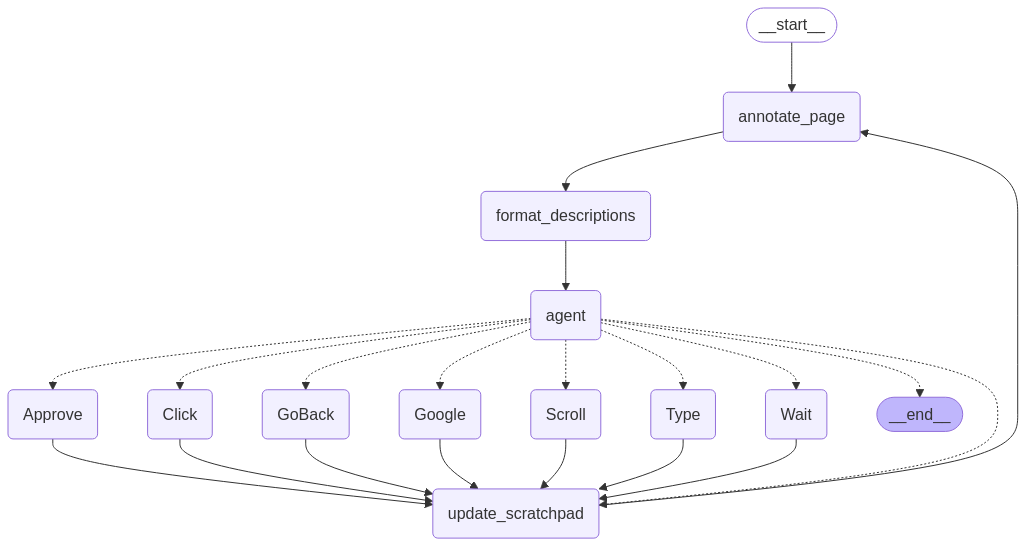

In [200]:
from IPython.display import display, Image
from langchain_core.runnables import RunnableLambda
from langgraph.graph import END, START, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from typing import Literal

AGENT = "agent"
FORMAT_DESCRIPTIONS = "format_descriptions"
ANNOTATE_PAGE = "annotate_page"
UPDATE_SCRATCHPAD = "update_scratchpad"


builder = StateGraph(AgentState)

builder.add_node(AGENT, agent)
builder.add_node(ANNOTATE_PAGE, annotate)
builder.add_node(FORMAT_DESCRIPTIONS, format_descriptions)
builder.add_node(UPDATE_SCRATCHPAD, update_scratchpad)

builder.add_edge(START, ANNOTATE_PAGE)
builder.add_edge(ANNOTATE_PAGE, FORMAT_DESCRIPTIONS)
builder.add_edge(FORMAT_DESCRIPTIONS, AGENT)


builder.add_edge(UPDATE_SCRATCHPAD, ANNOTATE_PAGE)

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Google": to_google,
    "Approve": approve_info_box,
}


for tool_name, tool_func in tools.items():
    builder.add_node(tool_name, tool_func)
    builder.add_edge(tool_name, UPDATE_SCRATCHPAD)


nodes = Literal[
    "Click", "Type", "Scroll", "Wait", "GoBack", 
    "Google", "Approve", END, UPDATE_SCRATCHPAD,
    ]

def select_tool(state: AgentState) -> nodes:
    action = state.prediction.action
    if action == "ANSWER":
        return END
    if action == "retry":
        return AGENT
    return action

builder.add_conditional_edges(AGENT, select_tool)

memory = MemorySaver()
#graph = builder.compile(checkpointer=memory)
graph = builder.compile()
#print(graph.get_graph().draw_mermaid())

display(Image(graph.get_graph().draw_mermaid_png()))

In [201]:
from IPython import display
from playwright.async_api import async_playwright
import asyncio
import uuid
import base64

config ={
    "thread_id": str(uuid.uuid4()),
    "recursion_limit": 150,
    }

# Run the agent
async def test_agent(query: str, config: dict = config):
    # Start Playwright
    playwright = await async_playwright().start()

    # Launch the browser
    browser = await playwright.chromium.launch(
        executable_path="/usr/bin/chromium-browser",
        headless=False,  # Set to False to watch the agent navigate
        args=[
            '--no-sandbox',
            '--disable-blink-features=AutomationControlled',
        ],
    )

    # Open a new page
    page = await browser.new_page()

    # Navigate to Google
    await page.goto("https://www.google.com")
    await page.wait_for_selector("text=Godta alle", timeout=5000)  # Wait up to 5 seconds
    await page.click("text=Godta alle") 

    # Create an initial AgentState
    state = AgentState(
        page=page,
        input=query,
        img=None,
        bboxes=[],
        prediction=None,
        scratchpad=[],
        observation=None,
        ids=[]
    )

    # Run the agent
    try:
        # Iterate over the asynchronous generator
        event_stream = graph.astream(
            state,
            config=config,
        )

        final_answer = None
        steps = []
        async for event in event_stream:
            # Log relevant event details
            if "agent" in event:
                print("\n--- Agent Event ---")
                pred = event["agent"].get("prediction") or {}
                action = pred.action
                action_input = pred.args
                print(f"Action: {action}")
                print(f"Action Input: {action_input}")
                print(f"Observation: {event['agent'].get('observation')}")
                print(f"Scratchpad: {event['agent'].get('scratchpad', [])}")
                print(f"Bounding Boxes: {event['agent'].get('bboxes', [])}")
                print(f"Image: {event['agent'].get('img')}")
                display.clear_output(wait=True)
                steps.append(f"{len(steps) + 1}. {action}: {action_input}")
                print("\n".join(steps))
                display.display(display.Image(base64.b64decode(event["agent"]["img"])))
                if action == "ANSWER":
                    print(f"\nFinal answer: {action_input[0]}")
                    final_answer = action_input[0]
                    break

        print("Agent completed successfully.")
    finally:
        # Close the browser
        await browser.close()
        await playwright.stop()

    return final_answer

1. Click: ['2']
2. Google: []
3. Google: []
4. Google: []
5. Click: ['2']
6. Click: ['2']
7. Type: ['finn.no BMW iX xDrive40 2022']
8. Type: ['finn.no BMW iX xDrive40 2022']
9. Type: ['finn.no BMW iX xDrive40 2022']
10. Type: ['6', 'finn.no BMW iX xDrive40 2022']
11. Click: ['30']
12. Click: ['24']
13. Click: ['Godta alle']
14. Click: ['Godta alle']
15. Click: ['Godta alle']
16. Click: ['Godta alle']
17. Click: ['Godta alle']
18. Click: ['Godta alle']
19. Click: ['Godta alle']
20. Click: ['Godta alle']
21. Click: ['Godta alle']
22. Click: ['Godta alle']
23. Click: ['Godta alle']
24. Click: ['Godta alle']
25. Click: ['Godta alle']


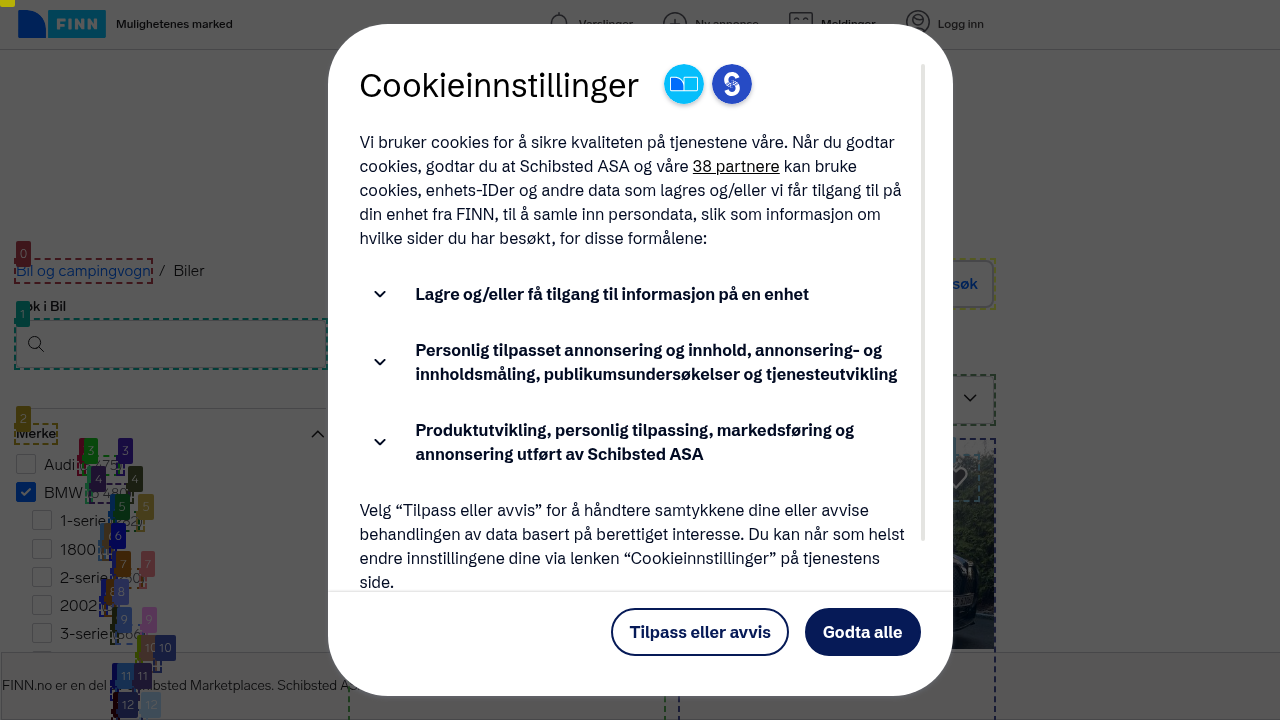

Error in click: invalid literal for int() with base 10: 'Godta alle'
Updated scratchpad:  Valid Bounding Boxes:
0 (<div/>): "no"
1 (<div/>): "Logg på"
2 (<a/>): "informasjonskapsler"
3. Clicked 2
4. Navigated to google.com
5. Navigated to google.com
6. Navigated to google.com
7. Clicked 2
8. Clicked 2
9. Failed to type in element from bounding box labeled as number ['finn.no BMW iX xDrive40 2022']
10. Failed to type in element from bounding box labeled as number ['finn.no BMW iX xDrive40 2022']
11. Failed to type in element from bounding box labeled as number ['finn.no BMW iX xDrive40 2022']
12. Typed 'finn.no BMW iX xDrive40 2022' and submitted
13. Clicked 30
14. Clicked 24
15. Error during click: invalid literal for int() with base 10: 'Godta alle'
16. Error during click: invalid literal for int() with base 10: 'Godta alle'
17. Error during click: invalid literal for int() with base 10: 'Godta alle'
18. Error during click: invalid literal for int() with base 10: 'Godta alle'
19. Erro

Exception: Browser.close: Connection closed while reading from the driver

In [202]:
# Run the test
res = await test_agent(
query=""""
Go to finn.no and search for 'BMW iX xDrive40 2022'. 
Click on the first result and scroll down to see the details.
"""  
)

In [ ]:
state_values = graph.get_state(config=config).values
state_values

{}

# Compile the Graph
Compile the agent's graph by defining nodes, edges, and conditional logic for tool selection.